## Importing Data and FMUs

In [1]:
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

from pyfmi import load_fmu
import scipy.io
from scipy.integrate import odeint
from library.predictor.predictor import Predictor


#Importing the file matlab of the cloud generated by Dymola

#mat_file = './data/m20240208Nuvola_1_7p.mat'   #small cloud at 13.00
#mat_file = './data/mreduction_PI.mat'
#mat_file2='./data/mstatic_comp.mat'
#mat_file2='./data/mreduction_static_comp.mat' #Step of 30%

mat_file = './data/mray_tracing.mat'

#mat_file = './data/m20240209Nuvola_12_7p.mat'  
#mat_file = './data/mNuvola_1_8AM.mat'       #small cloud at 8.00
#mat_file = './data/mNuvola_1_16_45.mat'
#mat_file='./data/mNuvolone1.mat'
#mat_file='./data/mNuvolone1_limit.mat'   #big cloud at 13.00
#mat_file='./data/mNuvola1_10_00.mat'
#mat_file='./data/mNuvolone3.mat'         #worst-case scenario
#mat_file='./data/mNuvolone3_wbasso.mat'
#mat_file='./data/mNuvolone3_const.mat'
#mat_file='./data/mNuvola10.mat'
#mat_file='./data/mNuvola_2_8AM.mat'
#mat_file='./data/mNuvola1_Longhi.mat'
#mat_file='./data/mNuvola1_8AM_reverse.mat'

#Importing the FMU


tube_fmu = './library/FMU/SolarReceiver2D_Examples_SM_07_0Delay_0estimation_0FMU.fmu'

controller_fmu='./library/FMU/SolarReceiver2D_Examples_SM_0static_0comp_0first_0guess_0FMU_0t_0all.fmu'

# Load the FMU controller 

controller=load_fmu(controller_fmu)

CSP_tube_model=[]
real_tube=[]
    
# Load the FMU tube
for j in range (0,7):
    CSP_tube_model.append(load_fmu(tube_fmu))
    real_tube.append(load_fmu(tube_fmu))

In [2]:
##------Details of the plant -----##

num_panels = 7
num_volumes_per_panel = 20  #21 nodes for 20 panels 

num_termometers = num_panels + 1
num_tot_volumes = num_panels*num_volumes_per_panel

print(f"The FMU has: {num_panels} panels")
print(f"The FMU has: {num_volumes_per_panel} axial volumes per panel")
print(f"The FMU has: {num_tot_volumes} total axial volumes" )

The FMU has: 7 panels
The FMU has: 20 axial volumes per panel
The FMU has: 140 total axial volumes


In [3]:
##--------Importing Data------##

tmp_mat_data = scipy.io.loadmat(mat_file) 
w_ = np.array(tmp_mat_data['flow'])  # The mass flow rate computed in Dymola 
w_dymola = np.array(tmp_mat_data['flow'])   # The mass flow rate computed in Dymola 

flux_table = np.array(tmp_mat_data['heatmap'])  
time_s = np.array(tmp_mat_data['time'])

d_sum_real=np.zeros(flux_table.shape[1])

for i in range(0, 1000):
    for j in range(0, num_tot_volumes):
        d_sum_real[i] += flux_table[j][i]/20

tmp_t_out_meas = np.array(tmp_mat_data['temperature'])
t_out_meas = np.zeros([num_termometers, tmp_t_out_meas.shape[1]])
for i in range(0, num_termometers):
    t_out_meas[i, :] = tmp_t_out_meas[i*num_volumes_per_panel, :]

b=np.zeros([num_termometers, tmp_t_out_meas.shape[1]])
for i in range (0, num_termometers):
    b[i,:]=tmp_t_out_meas[i*num_volumes_per_panel, :]

print(f"The flow rate has length: {w_.shape[0]}")
print(f"The t_out_meas has rows: {t_out_meas.shape[1]}")
print(f"The t_out_meas has columns: {t_out_meas.shape[0]}")


Tstart = float(time_s[0])
Tend = float(time_s[-1])

dt = round((Tend-Tstart)/len(time_s),2)

print(f"The simulation starts at {Tstart} and ends at time {Tend} with a dt of {dt} s")
Tstart

""""
tmp_mat_data2 = scipy.io.loadmat(mat_file2) # The mass flow rate computed in Dymola with the PI controller
w_dymola = np.array(tmp_mat_data2['flow'])
d_sum_real=np.array(tmp_mat_data2['average_flux'])

tmp_t_out_meas2 = np.array(tmp_mat_data2['temperature'])
t_out_dymola = np.zeros([num_termometers, tmp_t_out_meas.shape[1]])
for i in range(0, num_termometers):
    t_out_dymola[i, :] = tmp_t_out_meas2[i*num_volumes_per_panel, :]

d_sum_real=d_sum_real*7

"""

The flow rate has length: 1001
The t_out_meas has rows: 1001
The t_out_meas has columns: 8
The simulation starts at 0.0 and ends at time 1000.0 with a dt of 1.0 s


'"\ntmp_mat_data2 = scipy.io.loadmat(mat_file2) # The mass flow rate computed in Dymola with the PI controller\nw_dymola = np.array(tmp_mat_data2[\'flow\'])\nd_sum_real=np.array(tmp_mat_data2[\'average_flux\'])\n\ntmp_t_out_meas2 = np.array(tmp_mat_data2[\'temperature\'])\nt_out_dymola = np.zeros([num_termometers, tmp_t_out_meas.shape[1]])\nfor i in range(0, num_termometers):\n    t_out_dymola[i, :] = tmp_t_out_meas2[i*num_volumes_per_panel, :]\n\nd_sum_real=d_sum_real*7\n\n'

## Functions

In [4]:
def noisy(t_out,noise_level):
    noisy=t_out + random.uniform(-noise_level, noise_level)
    return noisy

In [5]:
# function that returns dx/dt that then will be integrated 
def ThermoCouple(x,t,u,Time_costant_sensor):
    tau_T= Time_costant_sensor
    dxdt = (-x + u)/tau_T   #Espressione di G(s)=1/(1+sT)
    return dxdt

In [6]:
def Non_negative(x):
    if x>=0:
        return x
    else:
        return 0

## Inizialization 

In [7]:
for j in range (0,7):
    CSP_tube_model[j].set('tin', 563.15)
    for n in range(0, num_volumes_per_panel):
        CSP_tube_model[j].set(f"d[{n+1}]", np.mean(flux_table[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0))
    CSP_tube_model[j].initialize()

In [8]:
for j in range (0,7):
    real_tube[j].set('tin', 563.15)
    for n in range(0, num_volumes_per_panel):
        real_tube[j].set(f"d[{n+1}]", np.mean(flux_table[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0))
    real_tube[j].initialize()

In [9]:
controller.set('d_estim_sum', 3500)
for j in range(0, 140):
    controller.set(f"T_out[{j+1}]", 563.15)
controller.set('T_out_7',563.15)
controller.initialize()

In [10]:
#controller.get_model_variables()

## Simulation

In [11]:
##-------------FMU SIMULATION---------------##
Time_costant_sensor=2
noise_level = 1 

w=np.zeros(flux_table.shape[1]+1)

d_meas = np.zeros([num_tot_volumes, flux_table.shape[1]])
d_meas_mean=np.zeros([num_panels,flux_table.shape[1]])

d_real =np.zeros([num_panels, num_volumes_per_panel, flux_table.shape[1]])


d_estim_panels = np.zeros([num_panels, flux_table.shape[1]+1])

d_estim_sum=np.zeros(flux_table.shape[1]+1)

d_estim = np.zeros([num_panels, num_volumes_per_panel, flux_table.shape[1]+1])

t_out_sim = np.zeros([num_termometers, flux_table.shape[1]])
first_order_deriv_estim = np.zeros([num_panels, flux_table.shape[1]])
first_order_deriv_meas = np.zeros([num_panels, flux_table.shape[1]])
t_error = np.zeros([num_panels, flux_table.shape[1]])
d_error = np.zeros([num_panels, flux_table.shape[1]])



for i in range(0, num_tot_volumes):  
    d_meas[i] = flux_table[i]    

for j in range(0, num_panels):
    for n in range (0, num_volumes_per_panel): 
         d_real[j][n][:] = d_meas[j*num_volumes_per_panel+n, :]



# Definition of the time data
time = Tstart    
print(f"The time step of the model is: {dt}s")


# Lists to store simulation results
simulation_results = []
time_sim = []  #time_simulation 


d_distribution = []

t_out_tube = np.zeros([num_termometers, flux_table.shape[1]])
t_out_tube_sim = np.zeros([num_termometers, flux_table.shape[1]])

for j in range(0,7):
    for n in range(0, num_volumes_per_panel):
        d_estim[j][n][:-1]=np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0)
    
    #d_estim_sum=d_estim_sum + np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0)

        
        
for j in range(0,7):
    d_meas_mean[j][:]=np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, :], axis=0)



#for j in range(0, num_tot_volumes):
#    for n in range(0,num_panels):
#        if num_volumes_per_panel*n <=j < num_volumes_per_panel*(n+1):
#            d_estim[j,:]=np.mean(d_meas[num_volumes_per_panel*n:num_volumes_per_panel*(n+1),:], axis=0)#### modifica ho messo axis=0


            
'''            
for j in range (0, num_panels):
    d_distribution.append([])
    for i in range (0, num_volumes_per_panel):
        d_distribution[j].append(d_meas[i+j*num_volumes_per_panel,0]/np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0))

'''

P_proportional=0
I_integrator = 0
correction_rule = []
for i in range(0, num_panels):
    correction_rule.append(Predictor(prop_gain=P_proportional, int_gain=I_integrator, dt=dt))

#-------Setting the state of the Predictor----------------###### 

for j in range(0,num_panels):    
    correction_rule[j].set_state(state=np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, 0], axis=0))
    
# Perform step-wise simulation

progress_bar = tqdm(total=len(time_sim), position=0, ncols=100, desc="Simulation Progress")


i = 0

# timemperature measurament points
t_out_sim_sens= np.zeros([num_termometers, flux_table.shape[1]])
t_out_meas_sens=np.zeros([num_termometers, flux_table.shape[1]])
t_out_meas_noisy=np.zeros([num_termometers, flux_table.shape[1]])
t_out_tube_sens=np.zeros([num_termometers, flux_table.shape[1]])

t_out_real=np.zeros([num_termometers, flux_table.shape[1]])
t_out_real=t_out_meas


P_value=np.zeros(flux_table.shape[1])
I_value=np.zeros(flux_table.shape[1])

Tmin=563.15

z0 = np.ones(num_termometers)*Tmin
p0 = np.ones(num_termometers)*Tmin
t0 = np.ones(num_termometers)*Tmin

SD_y=np.zeros([flux_table.shape[1]])


#------Final-----------------####

#0.001789 - -0.2357
#0.001196 - 0.008464

k=0.001789 
q=-0.2357

k_p=k
q_p=q

k_i=k  
q_i=q


d_estim_sum[:]=0
t_out_real=t_out_meas
w[:-1]=w_[:,0]
t_all =np.zeros([7, num_volumes_per_panel+1, flux_table.shape[1]])


while time <= Tend:
    
    P_value[i]=k_p*w[i]+q_p
    I_value[i]=k_i*w[i]+q_i
    
    for j in range(0, num_panels):
        correction_rule[j].update_parameters(P_value[i], I_value[i])
    ''''
    for j in range(0, num_termometers):
        if time>0:
            tspan = [time-dt,time]
            p = odeint(ThermoCouple,p0[j],tspan,args=(t_out_meas[j][i],Time_costant_sensor,))
        # store solution for plotting
            t_out_meas_sens[j][i] = p[1]
        # next initial condition
            p0[j] = p[1]
            
            t_out_meas_noisy[j][i]=noisy(t_out_meas_sens[j][i],noise_level)
    '''
    
    ##----------------------REAL TUBE FMU---------------------------##
    
    for j in range(0,num_panels):
        real_tube[j].time=time
        real_tube[j].set('w', w[i])
        for n in range(0, num_volumes_per_panel):
            real_tube[j].set(f"d[{n+1}]", d_real[j][n][i])
            
            
        real_tube[j].set('tin', t_out_real[j][i])
        
        status = real_tube[j].do_step(time, dt, True)
        if status  != 0:
            raise ValueError("There are some errors in the Step of the real tube FMU")
        t_out_real[j+1][i] = real_tube[j].get(f"flow2DFV_H.T[21]")
        for n in range(0,num_volumes_per_panel+1):
            t_all[j][n][i]=real_tube[j].get(f"flow2DFV_H.T[{n+1}]")
    
    ##----------------------DIGITAL TUBE FMU---------------------------##
    
    for j in range(0,num_panels):
        CSP_tube_model[j].time=time
        CSP_tube_model[j].set('w', w[i])
        for n in range(0, num_volumes_per_panel):
            CSP_tube_model[j].set(f"d[{n+1}]", d_estim[j][n][i])
            
            
        CSP_tube_model[j].set('tin', t_out_real[j][i])
        
        status4 = CSP_tube_model[j].do_step(time, dt, True)
        if status4  != 0:
            raise ValueError("There are some errors in the Step of the digital tube FMU")
        t_out_sim[j+1][i] = CSP_tube_model[j].get(f"flow2DFV_H.T[21]")

    # the first temperature sensor is equal to everybody bc it is the Tmin at 290° entering the receiver"
    
    t_out_sim[0][i]=t_out_real[0][i]

    #----------------------Controller FMU--------------------------##

    if i> 51:
        controller.time=time
        controller.set("d_estim_sum", d_estim_sum[i])
        for j in range(0, num_panels):
            for n in range(0, num_volumes_per_panel+1):
                controller.set(f"T_out[{j*num_volumes_per_panel + n+1}]",t_all[j][n][i])   
        controller.set("T_out_7", t_out_real[7][i])
        status_controller= controller.do_step(time,dt,True)
        if status_controller !=0:
            raise ValueError("There are some errors in the Step of the Controller FMU")
        w[i+1] = controller.get("limI.y")
        SD_y[i]=controller.get("SD.y")
    
    for j in range(0, num_panels):
        if i>50:
            #t_error[j, i] = (t_out_meas_noisy[j+1][i]) - (t_out_sim[j+1, i])
            t_error[j, i] = (t_out_real[j+1][i]) - (t_out_sim[j+1, i])
            d_estim_panels[j, i+1] = Non_negative(correction_rule[j].step(t_error[j,i]))
            for n in range (0, num_volumes_per_panel): 
                d_estim[j][n][i+1] = d_estim_panels[j, i+1]
            
            d_estim_sum[i+1] += d_estim_panels[j, i+1]
    
    time_sim.append(time)
    i = i+1
    time = time+dt
    progress_bar.update(1)
    progress_bar.set_postfix({"Percentage": f"{round((time / Tend),3) * 100:.1f}%"}, refresh=True)

w=w[:-1]
d_estim = d_estim[:][:][:-1]
d_estim_panels = d_estim_panels[:, :-1]
d_estim_sum = d_estim_sum[:-1]
#t_out_tube_sim = t_out_tube_sim[:, :-1]

##---Computing derivatives 
#for j in range(0, num_panels):
    #first_order_deriv_estim[j] = np.gradient(np.mean(d_estim[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, :], axis=0),time_sim)                             
    #first_order_deriv_meas[j] = np.gradient(np.mean(d_meas[j*num_volumes_per_panel:(j+1)*num_volumes_per_panel, :], axis=0), time_sim)                             

d_error= d_meas_mean-d_estim_panels 
#cost = np.sqrt( np.mean( t_error**2 ) )
cost = np.sqrt( np.mean( t_error[:,300:]**2 ))
cost_d=np.sqrt( np.mean( d_error[:,300:]**2 ))
               
if np.isnan(cost) or np.isinf(cost) or cost > 1e6:
    cost = 1e3

print(f"The temperature cost is: {cost}")
print(f"The disturbance cost is: {cost_d}")

progress_bar.close()


The time step of the model is: 1.0s


Simulation Progress: 0it [00:00, ?it/s]

Simulation Progress: 1001it [01:41,  9.90it/s, Percentage=100.1%]

The temperature cost is: 1.637249203890996
The disturbance cost is: 14.489179435355041


## Results

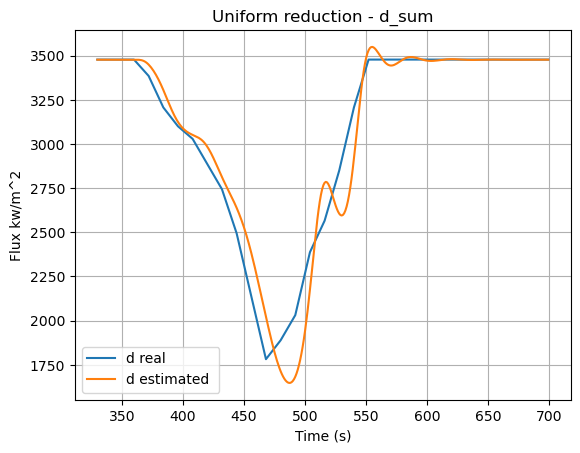

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


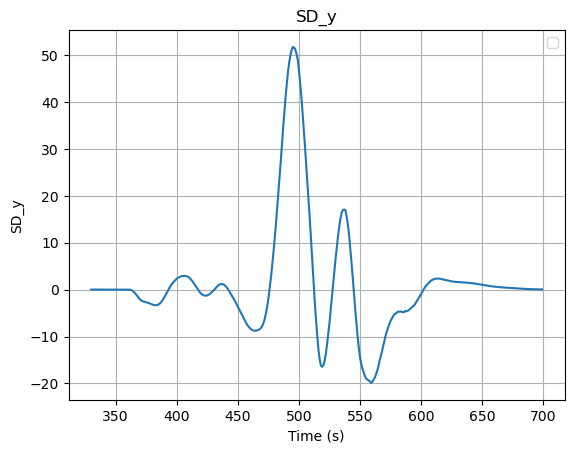

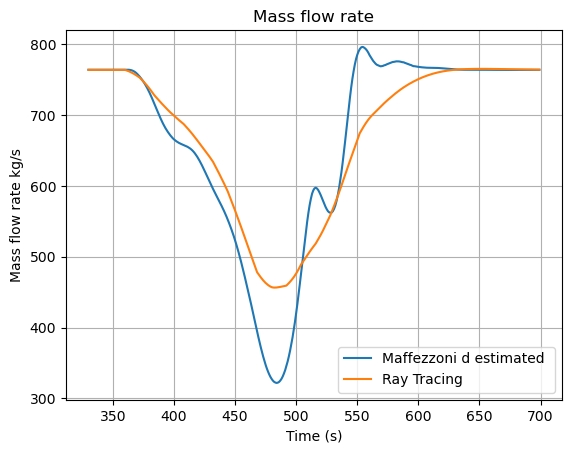

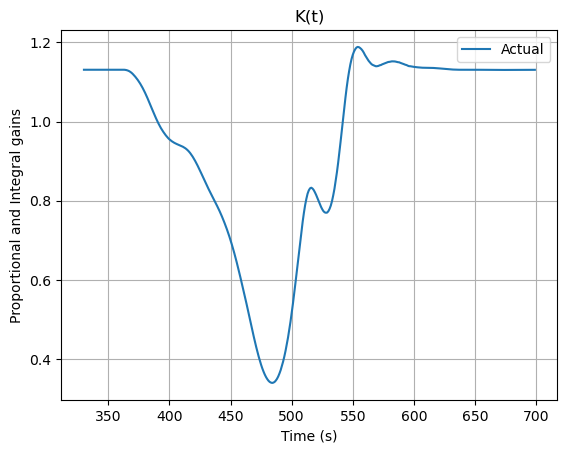

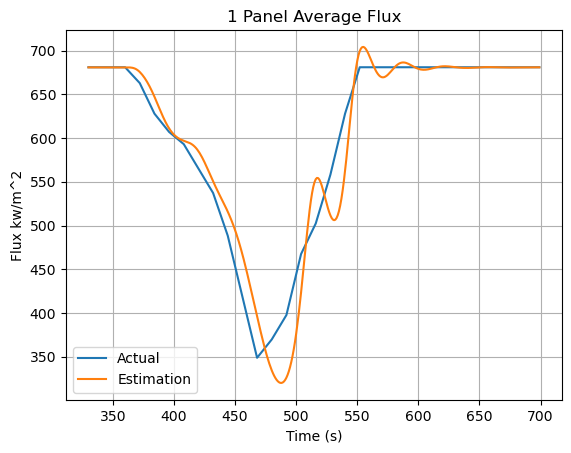

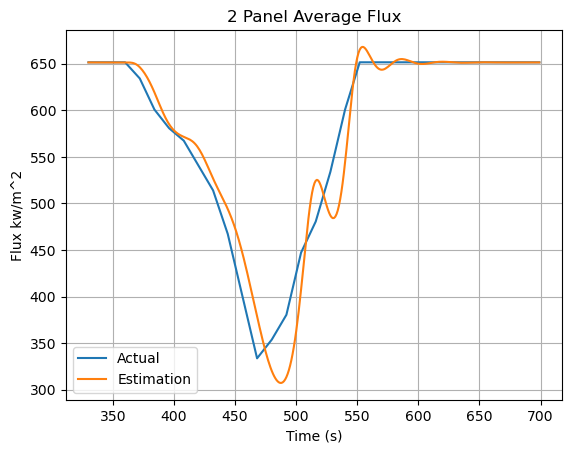

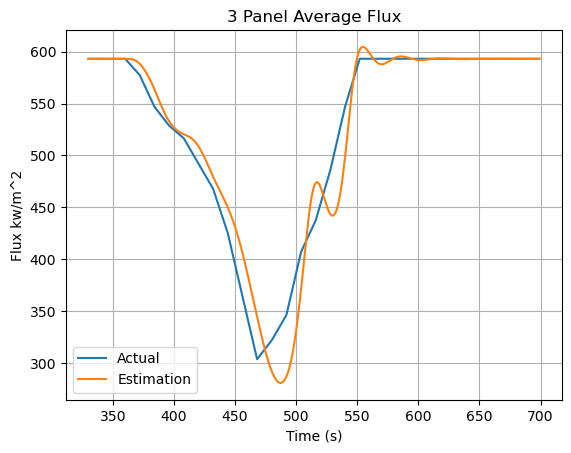

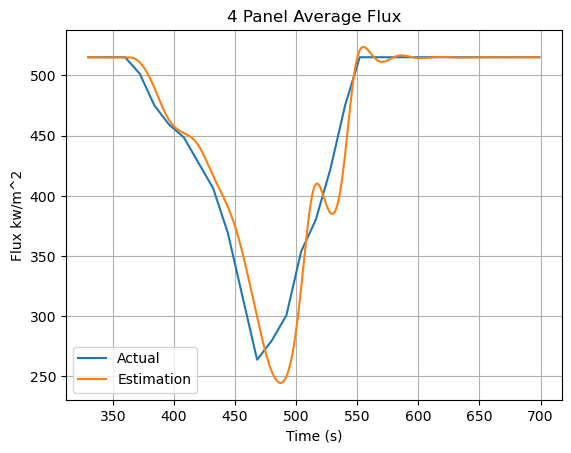

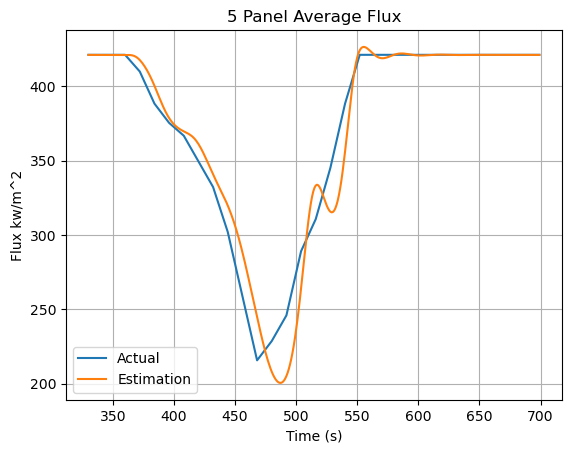

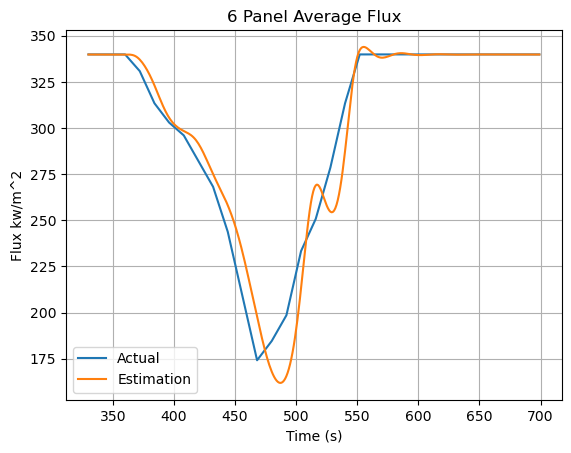

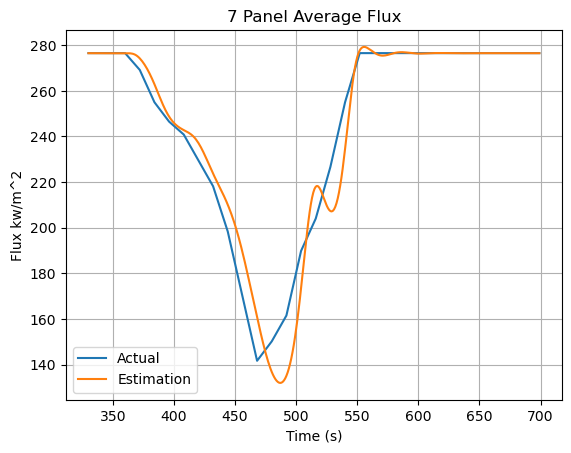

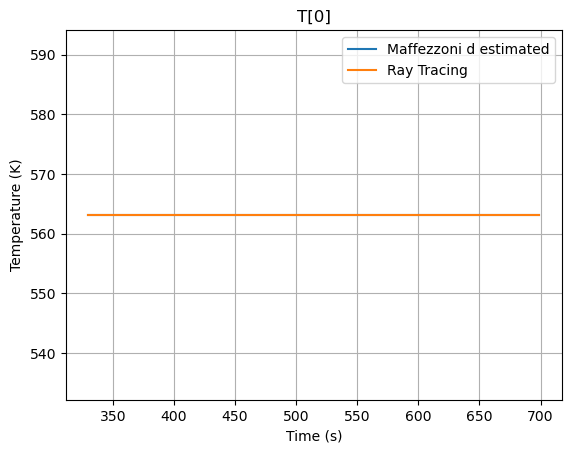

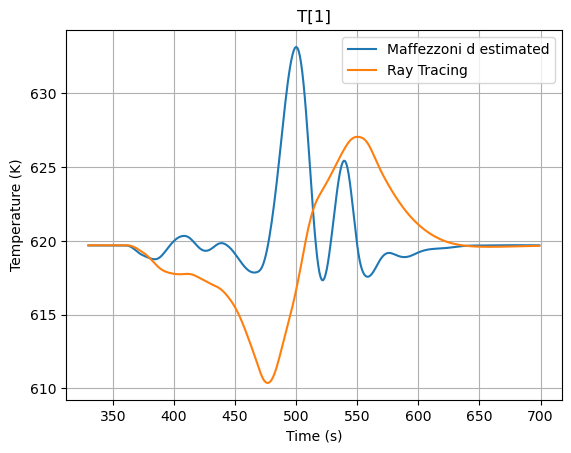

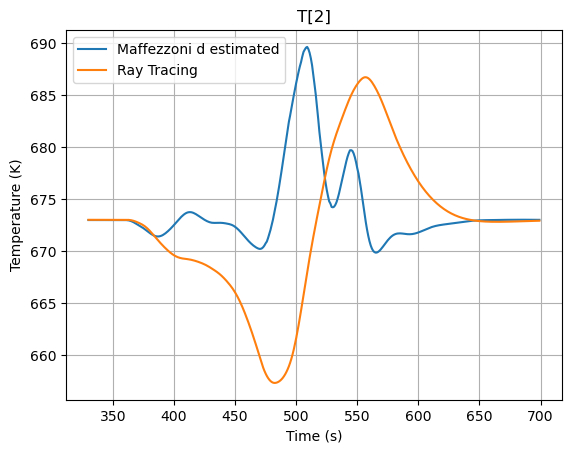

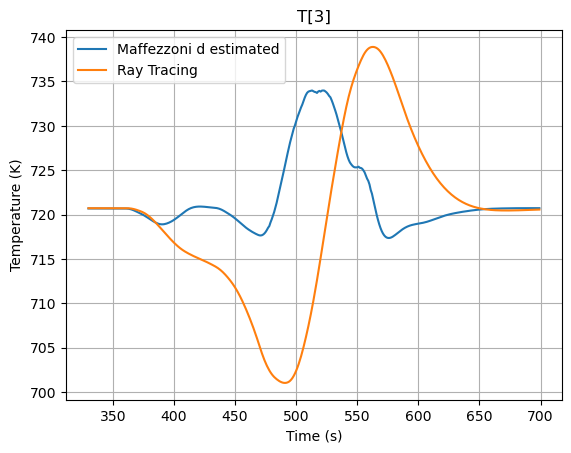

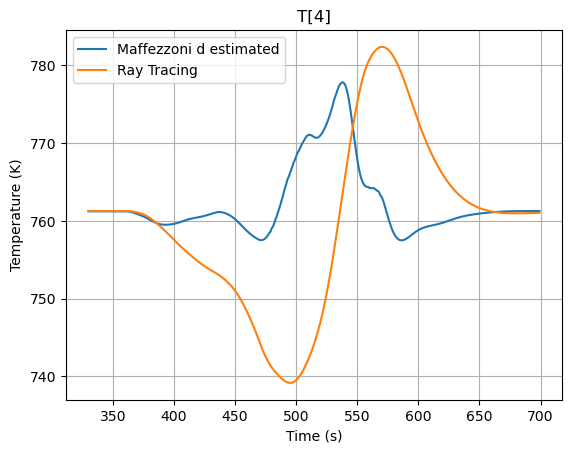

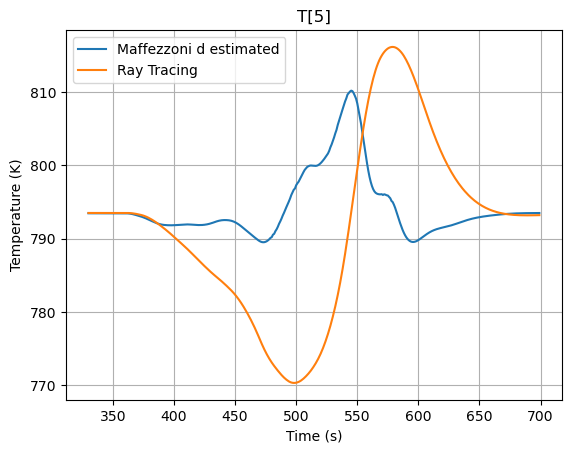

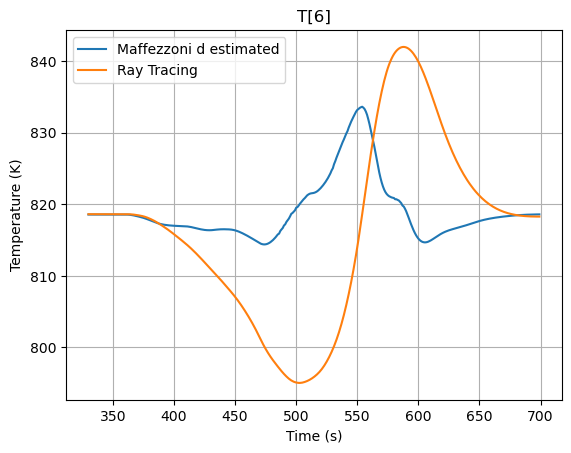

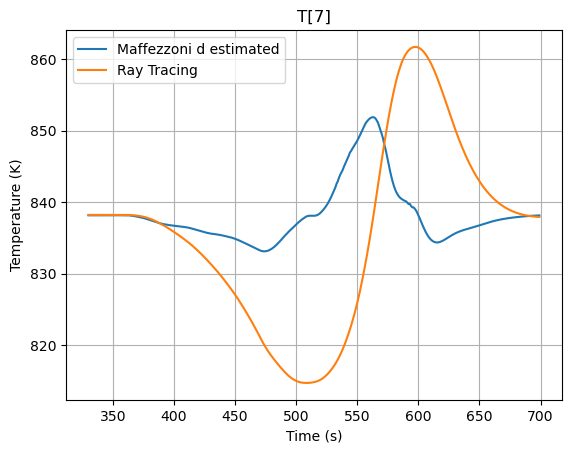

In [12]:
st=round(0.25*Tend/dt)  #1200 #starting time for the plot
ft=round(0.75*Tend/dt) #1350 finish time for the plot

st=round(0.33*Tend/dt)  #1200 #starting time for the plot
ft=round(0.7*Tend/dt)

#st=round(Tstart)
#ft=round(Tend)

#st=round(Tstart)
#ft=round(Tstart+100)

#st=round(0.3*Tend/dt)  #1200 #starting time for the plot
#ft=round(0.32*Tend/dt)

fig_d_sum=plt.figure()
plt.plot(time_sim[st:ft], d_sum_real[st:ft], label=f'd real')
plt.plot(time_sim[st:ft], d_estim_sum[st:ft], label=f'd estimated ')
plt.xlabel('Time (s)')
plt.ylabel('Flux kw/m^2')
plt.grid()
plt.legend()
plt.title('Uniform reduction - d_sum')
plt.show()
fig_d_sum.savefig(f'Images/d_sum.png', format='png', dpi=500)

plt.plot(time_sim[st:ft], SD_y[st:ft])
plt.xlabel('Time (s)')
plt.ylabel('SD_y')
plt.grid()
plt.legend()
plt.title('SD_y')
plt.show()

# Plot the simulation results
fig_w = plt.figure()
#plt.plot(time_sim[st:ft], w_dymola[st:ft], label=f'Maffezzoni d real')
plt.plot(time_sim[st:ft], w[st:ft], label=f'Maffezzoni d estimated ')
plt.plot(time_sim[st:ft], w_dymola[st:ft, 0], label=f'Ray Tracing')
plt.xlabel('Time (s)')
plt.ylabel('Mass flow rate kg/s')
plt.grid()
plt.legend()
plt.title('Mass flow rate')
plt.show()
fig_w.savefig(f'Images/w.png', format='png', dpi=500)

fig_k = plt.figure()
plt.plot(time_sim[st:ft], P_value[st:ft], label=f'Actual')
plt.xlabel('Time (s)')
plt.ylabel('Proportional and Integral gains')
plt.grid()
plt.legend()
plt.title('K(t)')
plt.show()
#fig_k.savefig(f'k.svg', format='svg', dpi=1000)

for j in range (0, num_panels):
     # Plot the simulation results
    
    fig_d = plt.figure()
    plt.plot(time_sim[st:ft], d_meas_mean[j][st:ft], label=f'Actual')
    plt.plot(time_sim[st:ft], d_estim_panels[j][st:ft], label=f'Estimation')
    plt.xlabel('Time (s)')
    plt.ylabel('Flux kw/m^2')
    plt.grid()
    plt.legend()
    plt.title(f'{j+1} Panel Average Flux')
    plt.show()
    fig_d.savefig(f'Images/Estimation{j+1}.png', format='png', dpi=500)


for j in range (0, num_termometers):
    
    fig_t = plt.figure()
    #plt.plot(time_sim[st:ft], t_out_dymola[j][st:ft], label=f'Maffezzoni d real')
    plt.plot(time_sim[st:ft],  t_out_real[j][st:ft], label=f'Maffezzoni d estimated')
    #plt.plot(time_sim[st:ft], t_out_sim[j][st:ft], linestyle='--', label=f'DT d estimated')
    plt.plot(time_sim[st:ft],  b[j][st:ft], label=f'Ray Tracing')
    #plt.plot(time_sim[st:ft], t_out_tube[j][st:ft], label=f'T_tube')
    #plt.plot(time_sim[st:ft], t_out_tube_sim[j][st:ft], label=f'T_tube_sim')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title(f'T[{j}]')
    plt.grid()
    plt.legend()
    plt.show()
    fig_t.savefig(f'Images/Temperature{j}.png', format='png', dpi=500)



## Others

In [13]:

''''
for j in range (0, num_termometers):
    
    #beingsaved = plt.figure()
    plt.plot(time_sim[st:ft],t_out_meas[j][st:ft],'g:',label='actual')
    plt.plot(time_sim[st:ft],t_out_meas_sens[j][st:ft],'b-',label='dynamic response sensor')
    plt.plot(time_sim[st:ft],t_out_meas_noisy[j][st:ft],'r-',label='sensor noise')
    plt.ylabel('Temperature [K]')
    plt.xlabel('Time (s)')
    plt.title(f'T[{j}] measured')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
   # beingsaved.savefig(f'Temperature{j}.eps', format='eps', dpi=1000)


    plt.plot(time_sim[st:ft],t_out_sim[j][st:ft],'g:',label='u(t)')
    #plt.plot(time_sim[st:ft],t_out_sim_sens[j][st:ft],'b-',label='x(t)')
    plt.ylabel('Temperature [K]')
    plt.xlabel('time')
    plt.title(f'T[{j}] simulated')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    
for j in range (0, num_panels):
    plt.plot(time_sim[st:ft], first_order_deriv_meas[j][st:ft], label=f'Actual')
    plt.plot(time_sim[st:ft], first_order_deriv_estim[j][st:ft], label=f'Estimation')
    plt.xlabel('Time (s)')
    plt.ylabel('')
    plt.grid()
    plt.legend()
    plt.title(f'Panel {j+1} average disturbance derivative 1_order')
    plt.show()

    

for j in range (0, num_panels):
    
    plt.plot(time_sim[st:ft], np.array(t_out_meas[(j+1)][st:ft]) - np.array(t_out_meas[j][st:ft]), label=f'Delta T_measured')
    plt.plot(time_sim[st:ft], np.array(t_out_sim[(j+1)][st:ft]) - np.array(t_out_sim[j][st:ft]), label=f'Delta T_simulated')
    plt.xlabel('Time (s)')
    plt.ylabel(f'T[{j+1}]-T[{j}]')
    plt.title(f'T[{j+1}]-T[{j}]')
    plt.grid()
    plt.legend()
    plt.show()


for j in range (0, num_panels):
    
    plt.plot(time_sim[st:ft], t_error[j,st:ft], label=f'T_error')
    plt.xlabel('Time (s)')
    plt.ylabel('T_error')
    plt.title(f'{j+1} T_error')
    plt.grid()
    plt.legend()
    plt.show()

for j in range (0, num_panels):
    
    plt.plot(time_sim[st:ft], d_error[j,st:ft], label=f'T_error')
    plt.xlabel('Time (s)')
    plt.ylabel('D_error')
    plt.title(f'{j+1} D_error')
    plt.grid()
    plt.legend()
    plt.show()
'''

"'\nfor j in range (0, num_termometers):\n    \n    #beingsaved = plt.figure()\n    plt.plot(time_sim[st:ft],t_out_meas[j][st:ft],'g:',label='actual')\n    plt.plot(time_sim[st:ft],t_out_meas_sens[j][st:ft],'b-',label='dynamic response sensor')\n    plt.plot(time_sim[st:ft],t_out_meas_noisy[j][st:ft],'r-',label='sensor noise')\n    plt.ylabel('Temperature [K]')\n    plt.xlabel('Time (s)')\n    plt.title(f'T[{j}] measured')\n    plt.legend(loc='best')\n    plt.grid()\n    plt.show()\n   # beingsaved.savefig(f'Temperature{j}.eps', format='eps', dpi=1000)\n\n\n    plt.plot(time_sim[st:ft],t_out_sim[j][st:ft],'g:',label='u(t)')\n    #plt.plot(time_sim[st:ft],t_out_sim_sens[j][st:ft],'b-',label='x(t)')\n    plt.ylabel('Temperature [K]')\n    plt.xlabel('time')\n    plt.title(f'T[{j}] simulated')\n    plt.legend(loc='best')\n    plt.grid()\n    plt.show()\n    \n    \nfor j in range (0, num_panels):\n    plt.plot(time_sim[st:ft], first_order_deriv_meas[j][st:ft], label=f'Actual')\n    plt.pl